<a href="https://colab.research.google.com/github/esterfb3397/fake-news-project-tfm/blob/main/preprocesado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Para acceder al repositorio actualizado desde otro Notebook

!git clone https://github.com/esterfb3397/fake-news-project-tfm.git


Cloning into 'fake-news-project-tfm'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 44 (delta 31), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (44/44), 6.41 MiB | 5.08 MiB/s, done.


#Librerias

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string 
import re 

 
from tqdm.autonotebook import tqdm
tqdm.pandas()

from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import (KFold, cross_val_score,cross_validate)
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


<ipython-input-2-4d05f2fe1794>:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
random_state = 1

In [4]:
#df = pd.read_excel('/content/clean_data.xlsx')
df = pd.read_pickle('/content/df.pickle')

In [5]:
df.head(2)

label                                         title_text  length  nwords  \
0      0  As U.S. budget fight looms, Republicans flip t...    4702     761   
1      0  U.S. military to accept transgender recruits o...    4120     632   

   avg_char_word  n_distint_word  
0       6.178712             424  
1       6.518987             338

Vemos que se ha cargado bastante bien, de momento vamos a eliminar las columnas subject,nwords,avg_char_word y n_distint_word

In [6]:
df = df.drop([ 'nwords','avg_char_word','n_distint_word'], axis=1)

In [7]:
df.head(2)

label                                         title_text  length
0      0  As U.S. budget fight looms, Republicans flip t...    4702
1      0  U.S. military to accept transgender recruits o...    4120

# Transformación

## Normalización
Vamos a proceder a normalizar los datos. Para ello vamos a generar pequeñas funciones que nos permitan:

- Transformar a minúsculas.


- Lematizar tokens.
- Tokenizar.
- Eliminar stopwords.
- Eliminar sígnos de puntuación.

In [8]:
#nos importamos un df limpio por si acaso
df = df.copy()

#### Eliminamos espacios

In [9]:
def eliminar_espacios(text): 
    return  " ".join(text.split())
df['espacios'] = df['title_text'].apply(eliminar_espacios)
df.head(2)

label                                         title_text  length  \
0      0  As U.S. budget fight looms, Republicans flip t...    4702   
1      0  U.S. military to accept transgender recruits o...    4120   

                                            espacios  
0  As U.S. budget fight looms, Republicans flip t...  
1  U.S. military to accept transgender recruits o...

#### Minusculas


In [10]:
# To lower
def texto_to_lower(text):
  return text.lower()
df['minusculas'] = df['espacios'].apply(texto_to_lower)
df.head(2)

label                                         title_text  length  \
0      0  As U.S. budget fight looms, Republicans flip t...    4702   
1      0  U.S. military to accept transgender recruits o...    4120   

                                            espacios  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   

                                          minusculas  
0  as u.s. budget fight looms, republicans flip t...  
1  u.s. military to accept transgender recruits o...

#### Quitamos posibles emojis


In [11]:
def clean_emoji(text):
    # Poner todos los comandos de http://www.unicode.org/Public/emoji/1.0/emoji-data.txt
    emoji_pattern = re.compile("["
        u"\U0001F300-\U0001F6FF"  # symbols & pictographs
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u'\u2600-\u26FF\u2700-\u27BF'
        u'\u2934' u'\u2935' u'\u2B05' u'\u2B06' u'\u2B07' u'\u2B1B' u'\u2B1C' 
        u'\u2B50' u'\u2B55' u'\u3030' u'\u303D' u'\u3297' u'\u3299' u'\u00A9'
        u'\u00AE' u'\u203C' u'\u2049' u'\u2122' u'\u2139' u'\u2194-\u2199' 
        u'\u21A9' u'\u21AA' u'\u231A' u'\u231B' u'\u2328' u'\u23CF'
        u'\u23E9-\u23F3' u'\u23F8' u'\u23F9' u'\u23FA' u'\u24C2' u'\u25AA'
        u'\u25AB' u'\u25B6' u'\u25C0' u'\u25FB' u'\u25FD' u'\u25FC' u'\u25FE'
        ']+', flags=re.UNICODE)
    string2 = re.sub(emoji_pattern,r' ',text)
    return string2
df['emojis'] = df['minusculas'].apply(clean_emoji)
df.head(2)

label                                         title_text  length  \
0      0  As U.S. budget fight looms, Republicans flip t...    4702   
1      0  U.S. military to accept transgender recruits o...    4120   

                                            espacios  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   

                                          minusculas  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                              emojis  
0  as u.s. budget fight looms, republicans flip t...  
1  u.s. military to accept transgender recruits o...

Quitamos html

In [12]:
from bs4 import BeautifulSoup

In [13]:
def strip_html(text):
  soup = BeautifulSoup(text,"html.parser")
  return soup.get_text()
df['html'] = df['emojis'].apply(strip_html)
df.head(2)


label                                         title_text  length  \
0      0  As U.S. budget fight looms, Republicans flip t...    4702   
1      0  U.S. military to accept transgender recruits o...    4120   

                                            espacios  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   

                                          minusculas  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                              emojis  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                                html  
0  as u.s. budget fight looms, republicans flip t...  
1  u.s. military to accept transgender recruits o...

Eliminar paréntesis

In [14]:
def remove_between_square_brackets(text):
  return re.sub('/[[^]]*\]','',text)
df['parentesis'] = df['html'].apply(strip_html)
df.tail(2)

label                                         title_text  length  \
22701      1  Federal Showdown Looms in Oregon After BLM Abu...   20747   
22702      1  A Troubled King: Chicago’s Rahm Emanuel Desper...    5833   

                                                espacios  \
22701  Federal Showdown Looms in Oregon After BLM Abu...   
22702  A Troubled King: Chicago’s Rahm Emanuel Desper...   

                                              minusculas  \
22701  federal showdown looms in oregon after blm abu...   
22702  a troubled king: chicago’s rahm emanuel desper...   

                                                  emojis  \
22701  federal showdown looms in oregon after blm abu...   
22702  a troubled king: chicago’s rahm emanuel desper...   

                                                    html  \
22701  federal showdown looms in oregon after blm abu...   
22702  a troubled king: chicago’s rahm emanuel desper...   

                                              parentesis  
22701  federal showdown looms in oregon after blm abu...  
22702  a troubled king: chicago’s rahm emanuel desper...

#### ELiminar URL

In [15]:
def url(text):
  return re.sub(r'http/S+','',text)
df['url'] = df['parentesis'].apply(strip_html)
df.head(2)

label                                         title_text  length  \
0      0  As U.S. budget fight looms, Republicans flip t...    4702   
1      0  U.S. military to accept transgender recruits o...    4120   

                                            espacios  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   

                                          minusculas  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                              emojis  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                                html  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                          parentesis  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                                 url  
0  as u.s. budget fight looms, republicans flip t...  
1  u.s. military to accept transgender recruits o...

Esto se va a eliminar mas tarde vamos a crear un length nuevo para ver como va el preprocesado

In [16]:
df['length_2'] = df['url'].apply(lambda x: len(x))


Tokenizador

In [17]:
import nltk

In [18]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [19]:
# Tokenizador
from nltk import word_tokenize

def tokenization(text):
  tokens = word_tokenize(text)
  return tokens

In [20]:
df['tokenizado'] = df['url'].apply(tokenization)

In [21]:
df.head(2)

label                                         title_text  length  \
0      0  As U.S. budget fight looms, Republicans flip t...    4702   
1      0  U.S. military to accept transgender recruits o...    4120   

                                            espacios  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   

                                          minusculas  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                              emojis  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                                html  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                          parentesis  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                                 url  length_2  \
0  as u.s. budget fight looms, republicans flip t...      4697   
1  u.s. military to accept transgender recruits o...      4118   

                                          tokenizado  
0  [as, u.s., budget, fight, looms, ,, republican...  
1  [u.s., military, to, accept, transgender, recr...

Quitar stopwords

In [22]:
from nltk.corpus import stopwords
def quitar_stopwords(tokens):
    stop_words = set(stopwords.words('english')) 
    filtered_sentence = [w for w in tokens if not w in stop_words]
    return filtered_sentence

In [23]:
df['stopwords'] = df['tokenizado'].apply(quitar_stopwords)
df.head(2)

label                                         title_text  length  \
0      0  As U.S. budget fight looms, Republicans flip t...    4702   
1      0  U.S. military to accept transgender recruits o...    4120   

                                            espacios  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   

                                          minusculas  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                              emojis  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                                html  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                          parentesis  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                                 url  length_2  \
0  as u.s. budget fight looms, republicans flip t...      4697   
1  u.s. military to accept transgender recruits o...      4118   

                                          tokenizado  \
0  [as, u.s., budget, fight, looms, ,, republican...   
1  [u.s., military, to, accept, transgender, recr...   

                                           stopwords  
0  [u.s., budget, fight, looms, ,, republicans, f...  
1  [u.s., military, accept, transgender, recruits...

Quitar puntuacion

In [24]:
def quitar_puntuacion(tokens):
    words=[word for word in tokens if word.isalnum()]
    return words
df['puntuacion'] = df['stopwords'].apply(quitar_puntuacion)
df.head(2)

label                                         title_text  length  \
0      0  As U.S. budget fight looms, Republicans flip t...    4702   
1      0  U.S. military to accept transgender recruits o...    4120   

                                            espacios  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   

                                          minusculas  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                              emojis  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                                html  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                          parentesis  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                                 url  length_2  \
0  as u.s. budget fight looms, republicans flip t...      4697   
1  u.s. military to accept transgender recruits o...      4118   

                                          tokenizado  \
0  [as, u.s., budget, fight, looms, ,, republican...   
1  [u.s., military, to, accept, transgender, recr...   

                                           stopwords  \
0  [u.s., budget, fight, looms, ,, republicans, f...   
1  [u.s., military, accept, transgender, recruits...   

                                          puntuacion  
0  [budget, fight, looms, republicans, flip, fisc...  
1  [military, accept, transgender, recruits, mond...

#### Steamming

In [25]:
import string
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
def stem(tokens):
    tokens = [ stemmer.stem(token) for token in tokens]
    return tokens


In [26]:
df['steam'] = df['puntuacion'].apply(stem)
df.head(2)

label                                         title_text  length  \
0      0  As U.S. budget fight looms, Republicans flip t...    4702   
1      0  U.S. military to accept transgender recruits o...    4120   

                                            espacios  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   

                                          minusculas  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                              emojis  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                                html  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                          parentesis  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                                 url  length_2  \
0  as u.s. budget fight looms, republicans flip t...      4697   
1  u.s. military to accept transgender recruits o...      4118   

                                          tokenizado  \
0  [as, u.s., budget, fight, looms, ,, republican...   
1  [u.s., military, to, accept, transgender, recr...   

                                           stopwords  \
0  [u.s., budget, fight, looms, ,, republicans, f...   
1  [u.s., military, accept, transgender, recruits...   

                                          puntuacion  \
0  [budget, fight, looms, republicans, flip, fisc...   
1  [military, accept, transgender, recruits, mond...   

                                               steam  
0  [budget, fight, loom, republican, flip, fiscal...  
1  [militari, accept, transgend, recruit, monday,...

se ha hecho el preprocesado, y antes de introducirlo a TFIDF vamos a generar una frase de gada una de las listas de tokens, para utilizar el propio tokenizador de TFIDF

In [27]:
df["clean_text"] = df["steam"].apply(lambda x: " ".join(x))

In [28]:
df.head(2)

label                                         title_text  length  \
0      0  As U.S. budget fight looms, Republicans flip t...    4702   
1      0  U.S. military to accept transgender recruits o...    4120   

                                            espacios  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   

                                          minusculas  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                              emojis  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                                html  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                          parentesis  \
0  as u.s. budget fight looms, republicans flip t...   
1  u.s. military to accept transgender recruits o...   

                                                 url  length_2  \
0  as u.s. budget fight looms, republicans flip t...      4697   
1  u.s. military to accept transgender recruits o...      4118   

                                          tokenizado  \
0  [as, u.s., budget, fight, looms, ,, republican...   
1  [u.s., military, to, accept, transgender, recr...   

                                           stopwords  \
0  [u.s., budget, fight, looms, ,, republicans, f...   
1  [u.s., military, accept, transgender, recruits...   

                                          puntuacion  \
0  [budget, fight, looms, republicans, flip, fisc...   
1  [military, accept, transgender, recruits, mond...   

                                               steam  \
0  [budget, fight, loom, republican, flip, fiscal...   
1  [militari, accept, transgend, recruit, monday,...   

                                          clean_text  
0  budget fight loom republican flip fiscal scrip...  
1  militari accept transgend recruit monday penta...

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


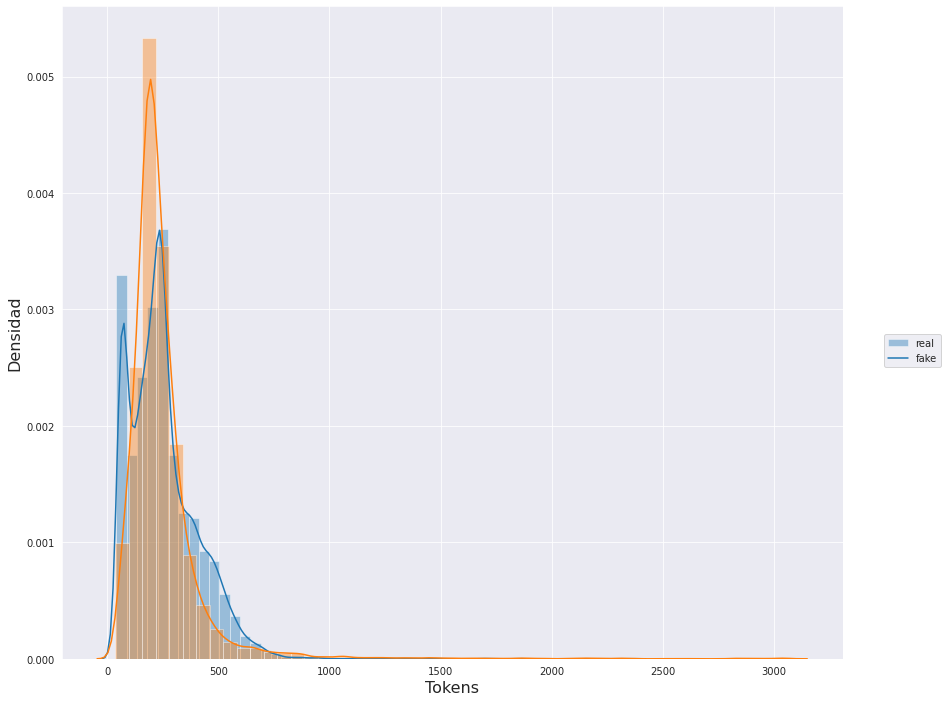

In [29]:
df["token_len"] = df['steam'].apply(lambda x: len(x))

fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")
plt1 = sns.distplot(df[df.label==0].token_len, hist=True, label="real")
plt2 = sns.distplot(df[df.label==1].token_len, hist=True, label="fake")
fig.legend(labels=['real','fake'],loc=5)

# Definimos el título de los ejes:
plt.xlabel('Tokens', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

plt.show()

En el gráfico podemos comprobar que las noticias reales agrupan una cantidad de tokens entre 0 y 700 y tienen una menor cantidad de densidad en comparacion con las noticas falsas queconcentran mas densidad de palabras

In [30]:
df['clean_text'] = df['clean_text'].str.replace("'","")

In [31]:
df['clean_text']

0        budget fight loom republican flip fiscal scrip...
1        militari accept transgend recruit monday penta...
2        senior republican senat mueller job special co...
3        fbi russia probe help australian diplomat nyt ...
4        trump want postal servic charg amazon shipment...
                               ...                        
22698    white hous theatric gun control 21st centuri w...
22699    activist terrorist media control dictat narr b...
22700    boiler room surrend retreat head roll ep 38 tu...
22701    feder showdown loom oregon blm abus local ranc...
22702    troubl king chicago rahm emanuel desper save 2...
Name: clean_text, Length: 32144, dtype: object

In [32]:
from wordcloud import WordCloud

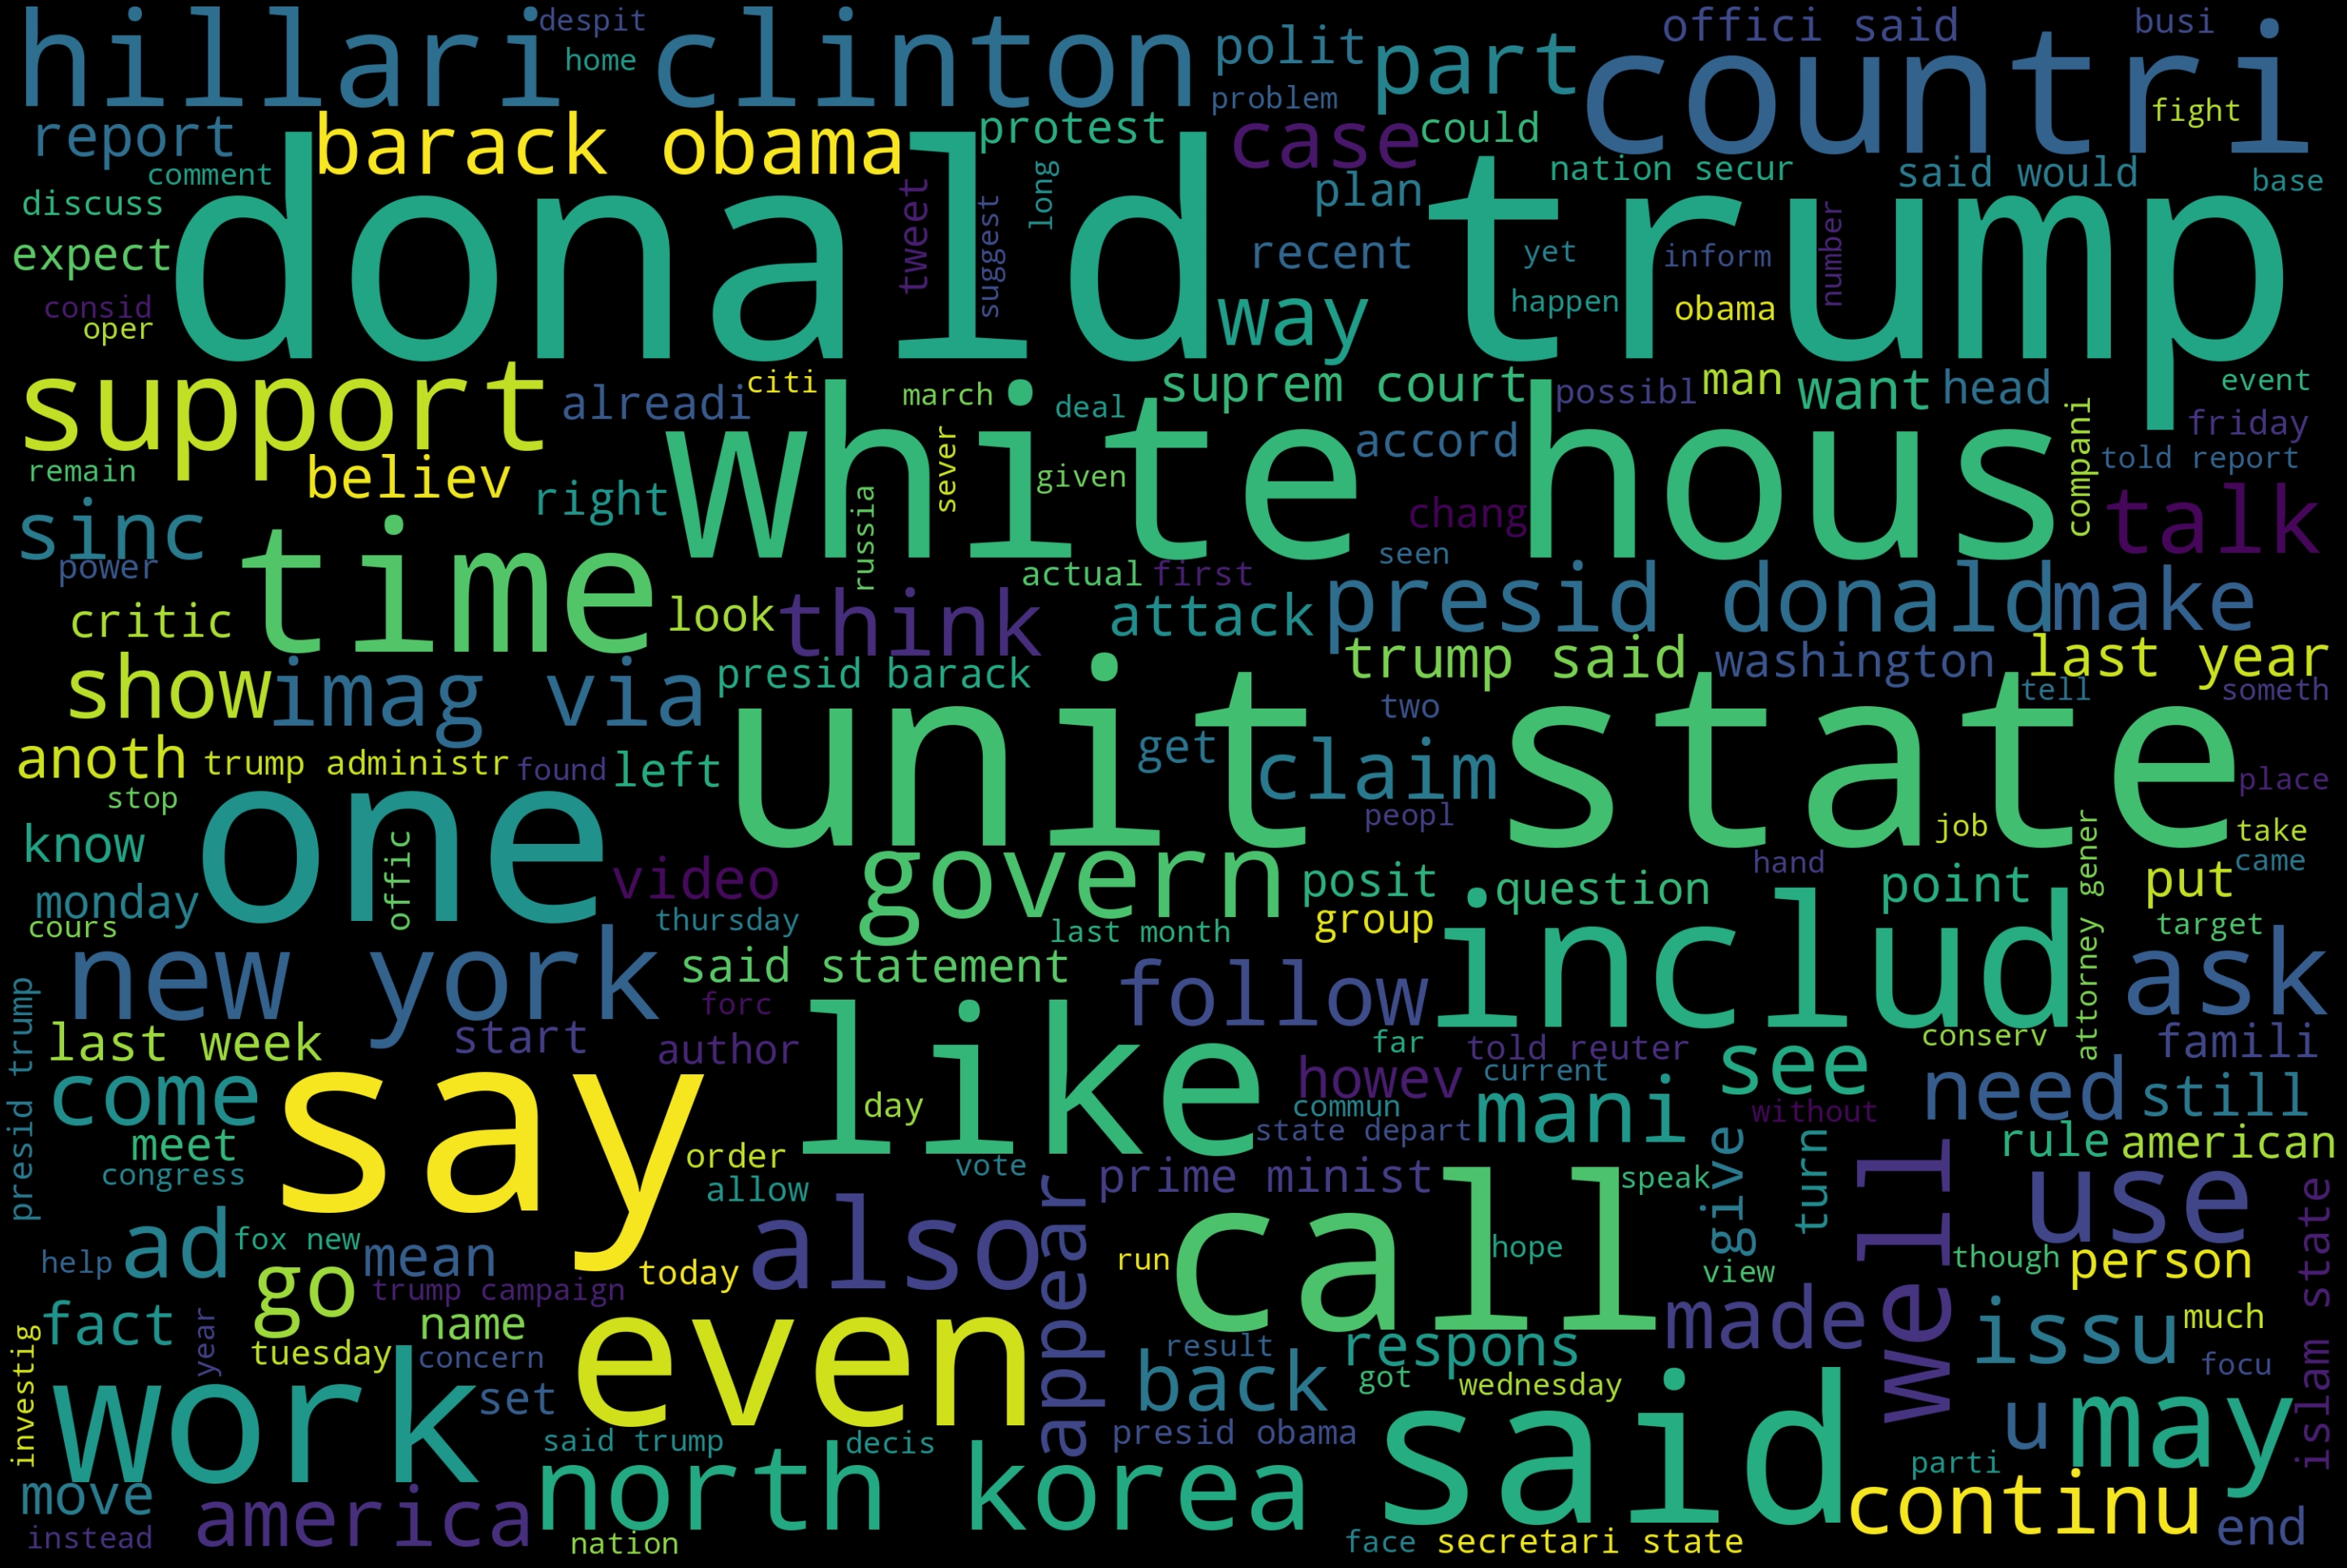

In [33]:
#Word Cloud
text = ''
for news in df.clean_text:
    text += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text


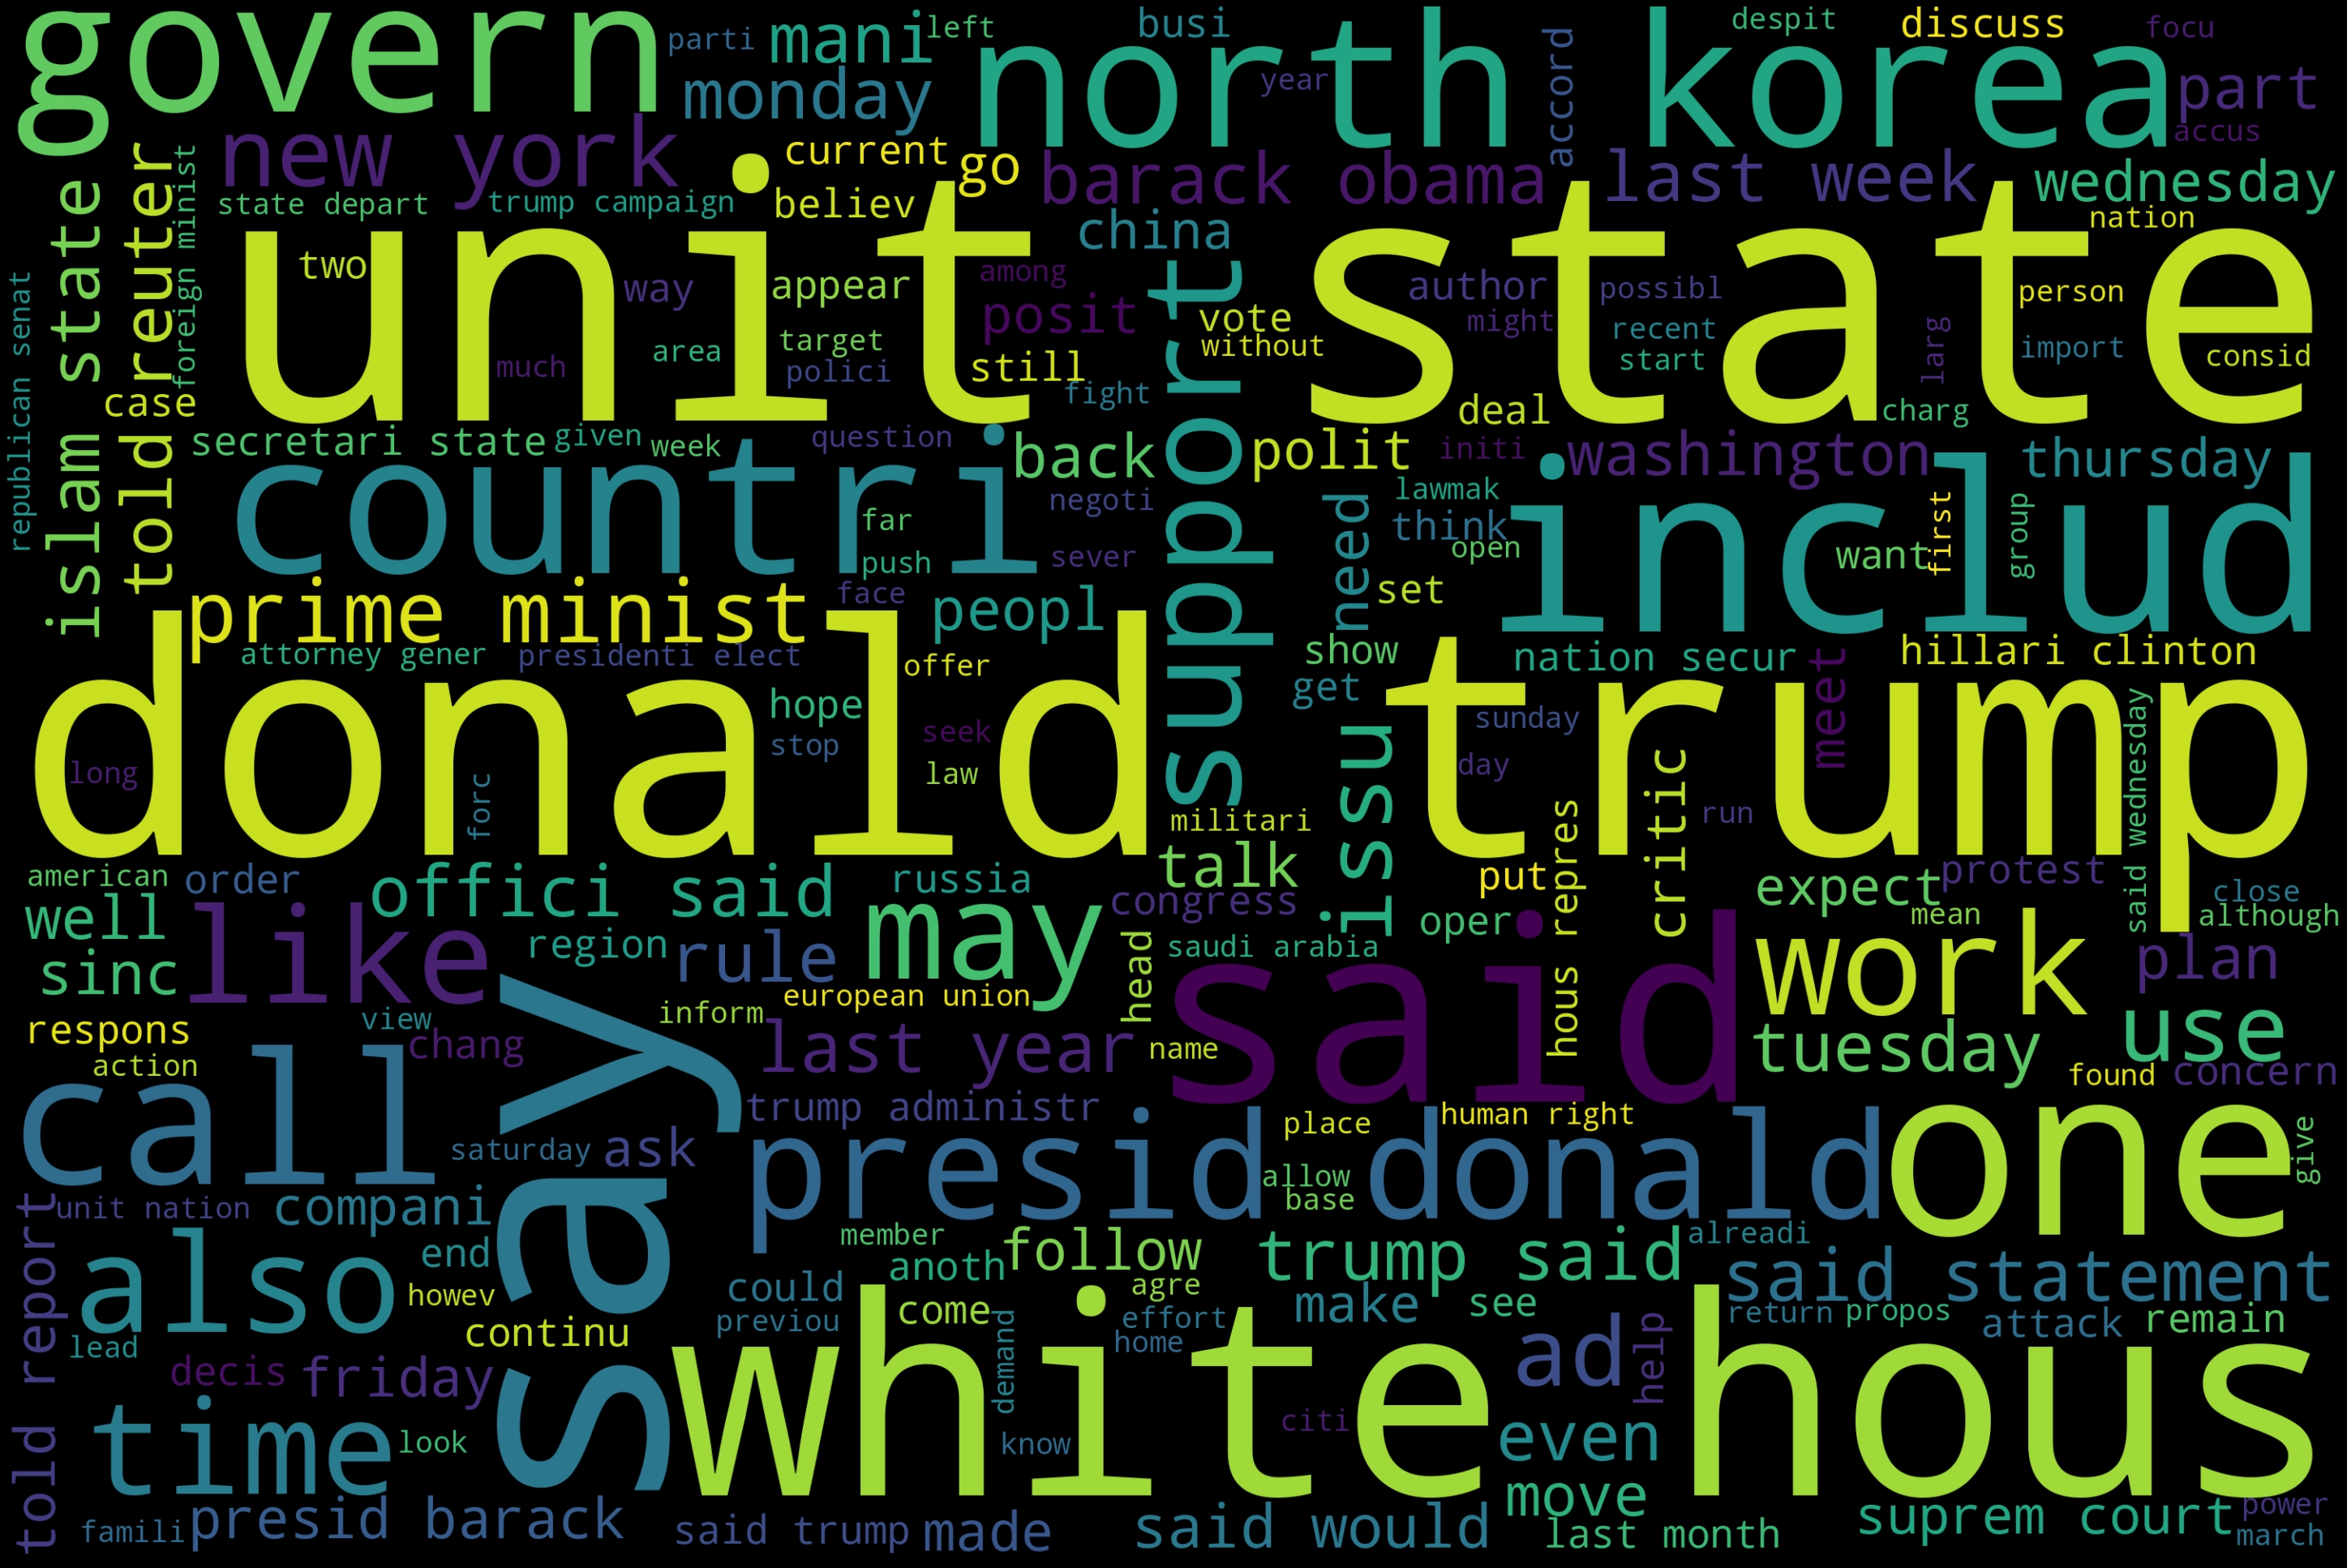

In [34]:
text = ''
for news in df[df.label==0].clean_text:
    text += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text


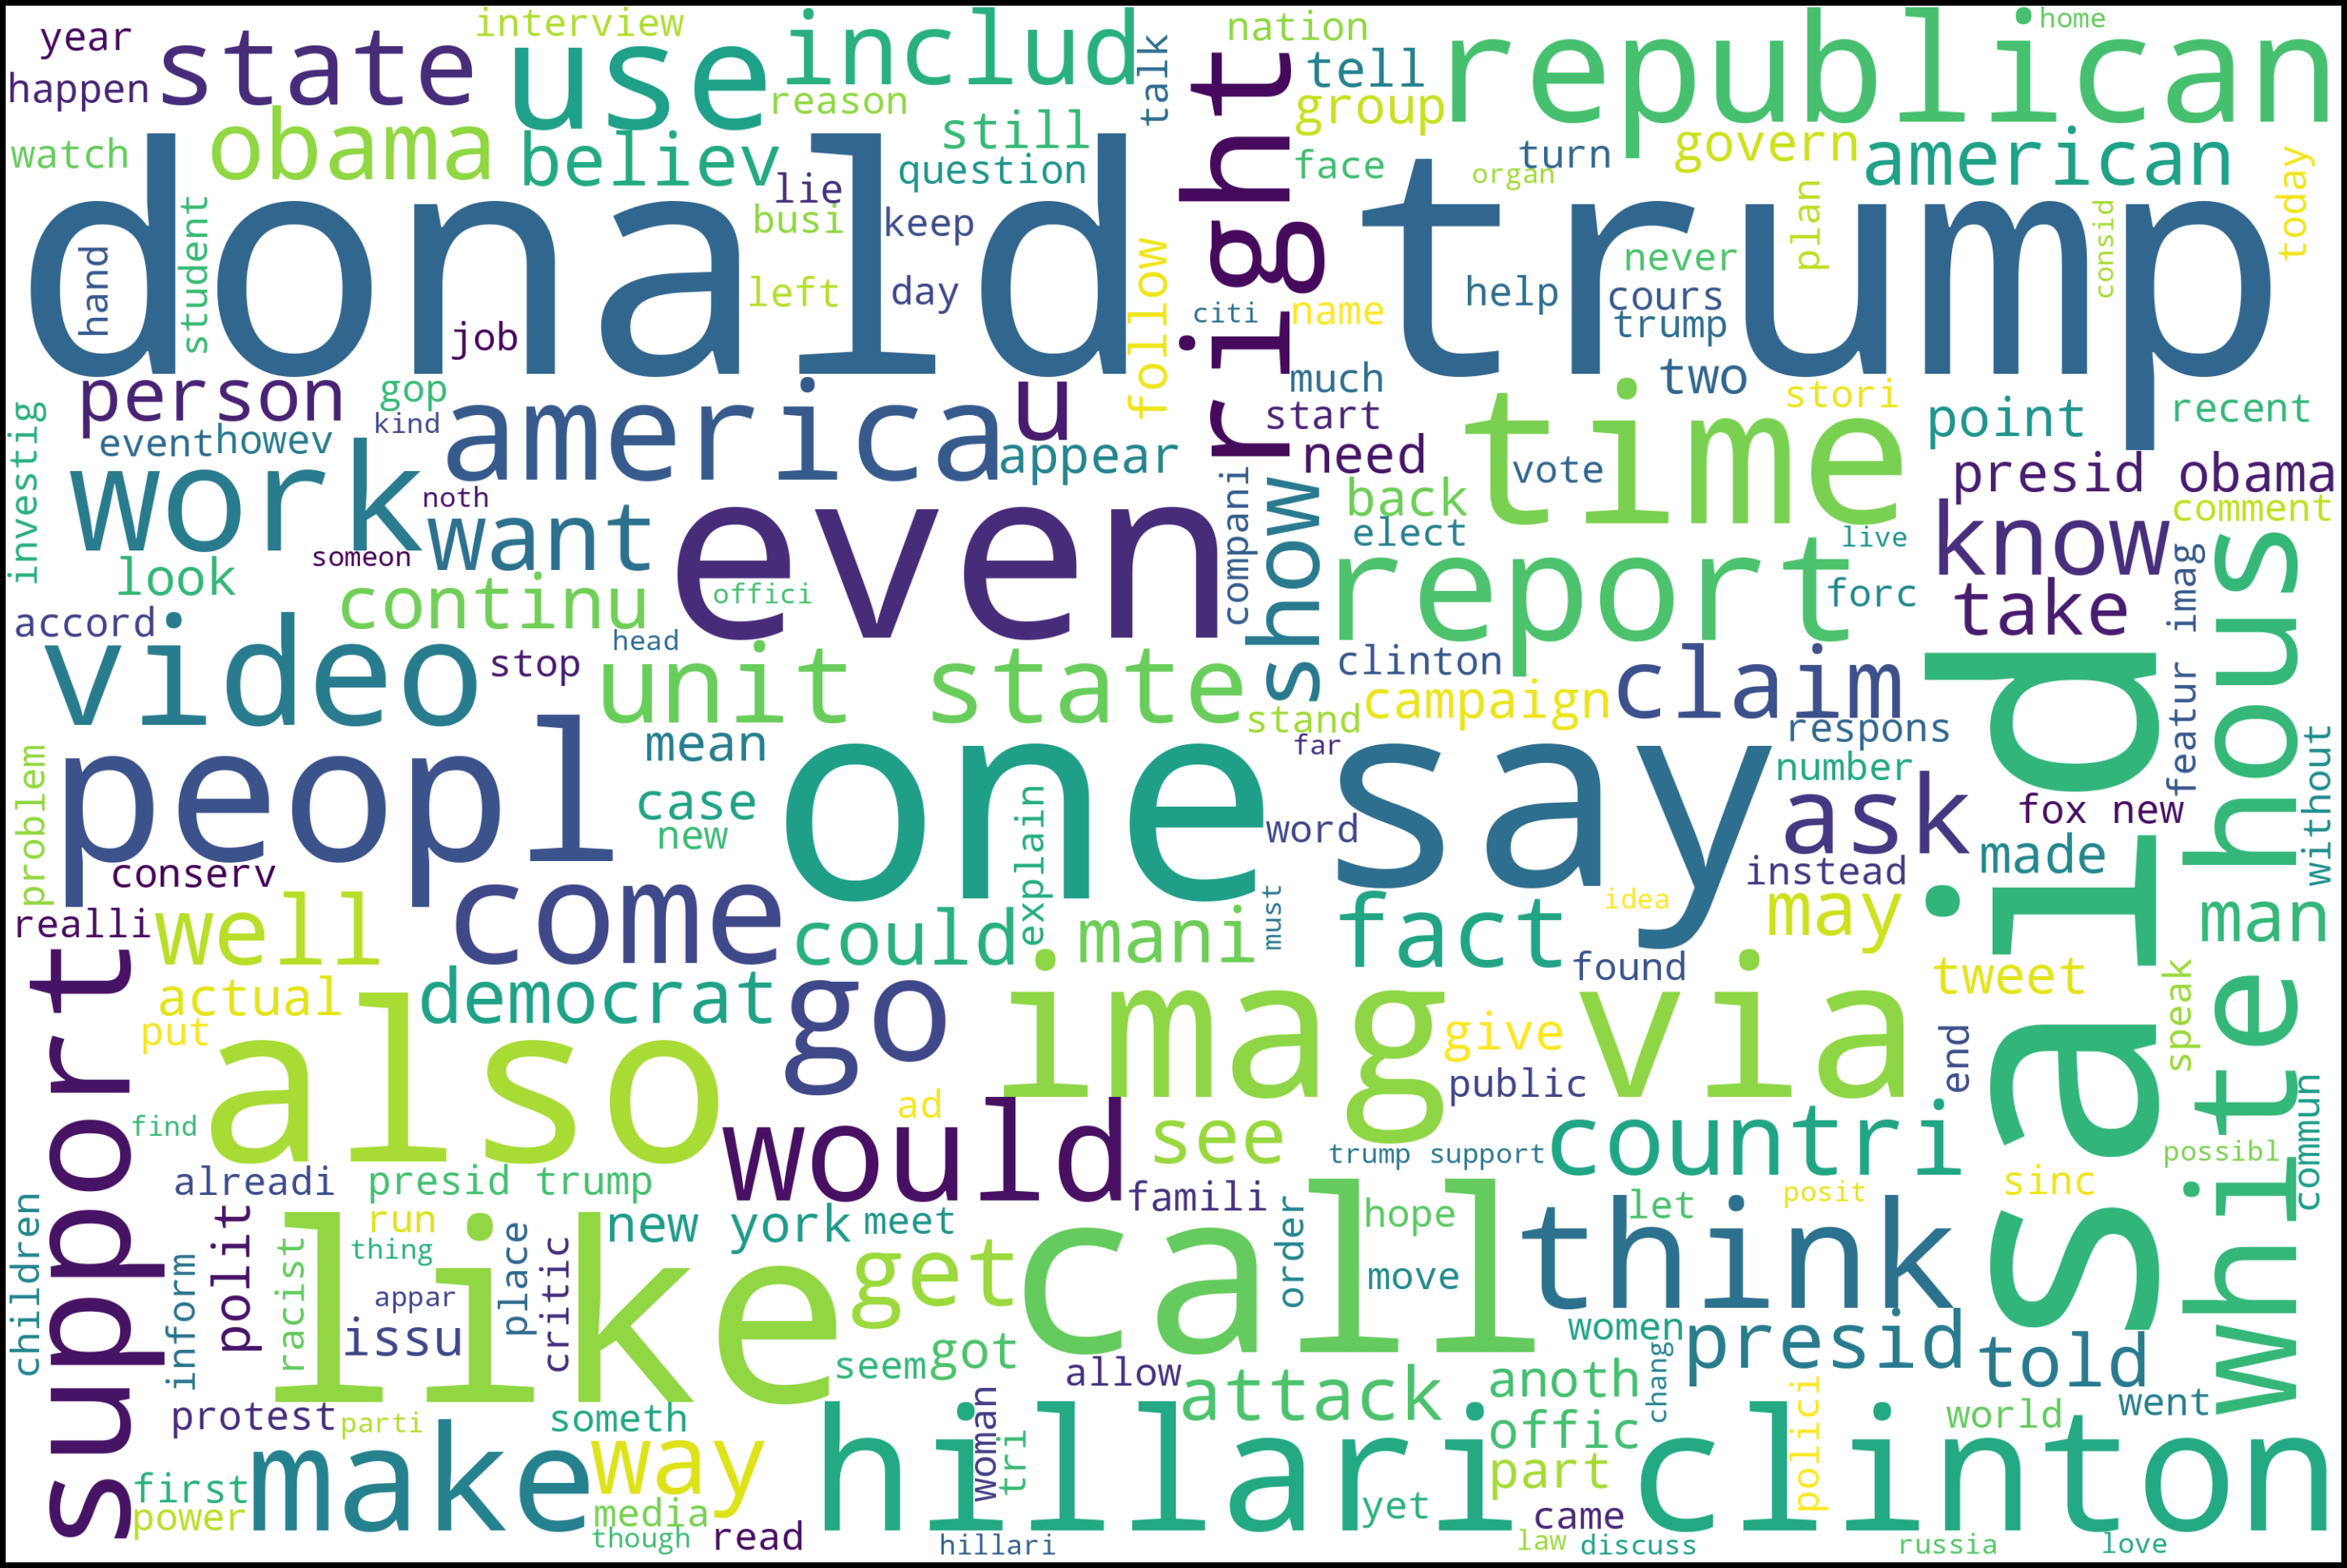

In [35]:
text = ''
for news in df[df.label==1].clean_text:
    text += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

## Vectorizacion

In [36]:
df.shape

(32144, 16)

In [37]:
df['clean_text'].dropna().shape

(32144,)

In [38]:
df[df['clean_text'].apply(lambda s: isinstance(s,int))]

Empty DataFrame
Columns: [label, title_text, length, espacios, minusculas, emojis, html, parentesis, url, length_2, tokenizado, stopwords, puntuacion, steam, clean_text, token_len]
Index: []

In [39]:
df[df['label'].apply(lambda s: isinstance(s,int))]

label                                         title_text  length  \
0          0  As U.S. budget fight looms, Republicans flip t...    4702   
1          0  U.S. military to accept transgender recruits o...    4120   
2          0  Senior U.S. Republican senator: 'Let Mr. Muell...    2828   
3          0  FBI Russia probe helped by Australian diplomat...    2499   
4          0  Trump wants Postal Service to charge 'much mor...    5244   
...      ...                                                ...     ...   
22698      1  The White House and The Theatrics of ‘Gun Cont...    7410   
22699      1  Activists or Terrorists? How Media Controls an...   26365   
22700      1  BOILER ROOM – No Surrender, No Retreat, Heads ...    1216   
22701      1  Federal Showdown Looms in Oregon After BLM Abu...   20747   
22702      1  A Troubled King: Chicago’s Rahm Emanuel Desper...    5833   

                                                espacios  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
22698  The White House and The Theatrics of ‘Gun Cont...   
22699  Activists or Terrorists? How Media Controls an...   
22700  BOILER ROOM – No Surrender, No Retreat, Heads ...   
22701  Federal Showdown Looms in Oregon After BLM Abu...   
22702  A Troubled King: Chicago’s Rahm Emanuel Desper...   

                                              minusculas  \
0      as u.s. budget fight looms, republicans flip t...   
1      u.s. military to accept transgender recruits o...   
2      senior u.s. republican senator: 'let mr. muell...   
3      fbi russia probe helped by australian diplomat...   
4      trump wants postal service to charge 'much mor...   
...                                                  ...   
22698  the white house and the theatrics of ‘gun cont...   
22699  activists or terrorists? how media controls an...   
22700  boiler room – no surrender, no retreat, heads ...   
22701  federal showdown looms in oregon after blm abu...   
22702  a troubled king: chicago’s rahm emanuel desper...   

                                                  emojis  \
0      as u.s. budget fight looms, republicans flip t...   
1      u.s. military to accept transgender recruits o...   
2      senior u.s. republican senator: 'let mr. muell...   
3      fbi russia probe helped by australian diplomat...   
4      trump wants postal service to charge 'much mor...   
...                                                  ...   
22698  the white house and the theatrics of ‘gun cont...   
22699  activists or terrorists? how media controls an...   
22700  boiler room – no surrender, no retreat, heads ...   
22701  federal showdown looms in oregon after blm abu...   
22702  a troubled king: chicago’s rahm emanuel desper...   

                                                    html  \
0      as u.s. budget fight looms, republicans flip t...   
1      u.s. military to accept transgender recruits o...   
2      senior u.s. republican senator: 'let mr. muell...   
3      fbi russia probe helped by australian diplomat...   
4      trump wants postal service to charge 'much mor...   
...                                                  ...   
22698  the white house and the theatrics of ‘gun cont...   
22699  activists or terrorists? how media controls an...   
22700  boiler room – no surrender, no retreat, heads ...   
22701  federal showdown looms in oregon after blm abu...   
22702  a troubled king: chicago’s rahm emanuel desper...   

                                              parentesis  \
0      as u.s. budget fight looms, republicans flip t...   
1      u.s. military to accept transgender recruits o...   
2      senior u.s. republican senator: 'le

In [40]:
vectorizador = TfidfVectorizer(max_features=30,ngram_range= (1,3) ,min_df = 0.01,lowercase = False)

vector_data = vectorizador.fit_transform(df['clean_text'])

In [41]:
vector_data

<32144x30 sparse matrix of type '<class 'numpy.float64'>'
	with 388530 stored elements in Compressed Sparse Row format>

In [42]:
df.dropna()

label                                         title_text  length  \
0          0  As U.S. budget fight looms, Republicans flip t...    4702   
1          0  U.S. military to accept transgender recruits o...    4120   
2          0  Senior U.S. Republican senator: 'Let Mr. Muell...    2828   
3          0  FBI Russia probe helped by Australian diplomat...    2499   
4          0  Trump wants Postal Service to charge 'much mor...    5244   
...      ...                                                ...     ...   
22698      1  The White House and The Theatrics of ‘Gun Cont...    7410   
22699      1  Activists or Terrorists? How Media Controls an...   26365   
22700      1  BOILER ROOM – No Surrender, No Retreat, Heads ...    1216   
22701      1  Federal Showdown Looms in Oregon After BLM Abu...   20747   
22702      1  A Troubled King: Chicago’s Rahm Emanuel Desper...    5833   

                                                espacios  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
22698  The White House and The Theatrics of ‘Gun Cont...   
22699  Activists or Terrorists? How Media Controls an...   
22700  BOILER ROOM – No Surrender, No Retreat, Heads ...   
22701  Federal Showdown Looms in Oregon After BLM Abu...   
22702  A Troubled King: Chicago’s Rahm Emanuel Desper...   

                                              minusculas  \
0      as u.s. budget fight looms, republicans flip t...   
1      u.s. military to accept transgender recruits o...   
2      senior u.s. republican senator: 'let mr. muell...   
3      fbi russia probe helped by australian diplomat...   
4      trump wants postal service to charge 'much mor...   
...                                                  ...   
22698  the white house and the theatrics of ‘gun cont...   
22699  activists or terrorists? how media controls an...   
22700  boiler room – no surrender, no retreat, heads ...   
22701  federal showdown looms in oregon after blm abu...   
22702  a troubled king: chicago’s rahm emanuel desper...   

                                                  emojis  \
0      as u.s. budget fight looms, republicans flip t...   
1      u.s. military to accept transgender recruits o...   
2      senior u.s. republican senator: 'let mr. muell...   
3      fbi russia probe helped by australian diplomat...   
4      trump wants postal service to charge 'much mor...   
...                                                  ...   
22698  the white house and the theatrics of ‘gun cont...   
22699  activists or terrorists? how media controls an...   
22700  boiler room – no surrender, no retreat, heads ...   
22701  federal showdown looms in oregon after blm abu...   
22702  a troubled king: chicago’s rahm emanuel desper...   

                                                    html  \
0      as u.s. budget fight looms, republicans flip t...   
1      u.s. military to accept transgender recruits o...   
2      senior u.s. republican senator: 'let mr. muell...   
3      fbi russia probe helped by australian diplomat...   
4      trump wants postal service to charge 'much mor...   
...                                                  ...   
22698  the white house and the theatrics of ‘gun cont...   
22699  activists or terrorists? how media controls an...   
22700  boiler room – no surrender, no retreat, heads ...   
22701  federal showdown looms in oregon after blm abu...   
22702  a troubled king: chicago’s rahm emanuel desper...   

                                              parentesis  \
0      as u.s. budget fight looms, republicans flip t...   
1      u.s. military to accept transgender recruits o...   
2      senior u.s. republican senator: 'le

## Entrenamiento y evaluación de modelos


El primer paso es definir las variables predictoras, que son las características extraidas anteriormente a través de TF-IDF. 

También especificaremos cual es la variable con las clases de cada documento.


In [43]:
# Importamos numpy:
import numpy as np

# Definimos la variable de categorías:
y = df["label"]

print(y.shape)

(32144,)


In [44]:
X_train, X_test, y_train, y_test = train_test_split(vector_data, y , random_state=random_state)
print(X_train.shape)
print(X_test.shape)

(24108, 30)
(8036, 30)


**Decision de modelo de ML a utilizar**

En primer lugar se ha generado una función para medir la calidad de varios modelos estándar de forma fácil y ver sus resultados. 

La función hace un KFold y evalua diferentes modelos con una métrica de evaluación:

In [45]:
import warnings
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings 

In [46]:
# Definimos la función encargada de evaluar los modelos:
def model_evaluation(models, score, X, y):
      results = []
      names = []
      #PAra cada modelo
      for name, model in models:
          warnings.filterwarnings('ignore') 
         # hacemos croos_val
          cv_results = cross_val_score(model, X, y, cv = 5, scoring = score, verbose = False)
          
          # Guardamos los resultados:
          results.append(cv_results)
          names.append(name)
          
          # Mostramos los resultados numéricamente:
          print('Metric: {} , KFold '.format(str(score)))
          print("%s: %f (%f) " % (name, cv_results.mean(), cv_results.std()))

      return results, names

In [102]:
# Cargamos los modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from sklearn.linear_model import SDGClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB





# Definimos los modelos y generamos una lista con cada uno de ellos:
models = [
         ("LogisticRegression",LogisticRegression(random_state = random_state)), # Logistic ¡Regression
         ("GaussianNB",GaussianNB()),
         ("LinearSVC",LinearSVC()),
          ("MultinomialNB", MultinomialNB()),
          ("MLPClassifier", MLPClassifier())
]

evaluation_score = "accuracy"

model_evaluation(models,  evaluation_score, vector_data.toarray(), y) 
  

Metric: accuracy , KFold 
LogisticRegression: 0.834059 (0.033665) 
Metric: accuracy , KFold 
GaussianNB: 0.762911 (0.042909) 
Metric: accuracy , KFold 
LinearSVC: 0.833468 (0.034473) 
Metric: accuracy , KFold 
MultinomialNB: 0.769599 (0.055464) 
Metric: accuracy , KFold 
MLPClassifier: 0.858262 (0.030027) 


([array([0.8853632 , 0.85860943, 0.79048063, 0.82034531, 0.81549471]),
  array([0.81334578, 0.77834811, 0.68362109, 0.77445948, 0.76477909]),
  array([0.88505211, 0.85907606, 0.78736973, 0.82081195, 0.815028  ]),
  array([0.85192098, 0.77368175, 0.68393218, 0.79421372, 0.74424393]),
  array([0.89034064, 0.8805413 , 0.81070151, 0.87354176, 0.83618544])],
 ['LogisticRegression',
  'GaussianNB',
  'LinearSVC',
  'MultinomialNB',
  'MLPClassifier'])

#### Modelo 1

In [49]:
df["label"] = df["label"].astype(str)
df["clean_text"] = df["clean_text"].astype(str)

In [50]:
model1 = GridSearchCV(
    estimator=Pipeline(
        steps = [
            ("TfidfVectorizer", TfidfVectorizer(
                lowercase = True,
                max_features = 1000
            )),
            ("LogisticRegression", LogisticRegression(
                random_state = random_state,
                class_weight = {"0":1, "1":5669/4831}
            ))
        ]
    ),
    param_grid = {
        "TfidfVectorizer__ngram_range": [(1,2), (1,3)],
        "LogisticRegression__C": [1e-3, 1e-4, 1e-5],
    },
    cv = 5,
    n_jobs = -1,
    verbose = 3
)

In [51]:
df_copy = df.sample(frac=1)#.head(300)
X_train, X_test, y_train, y_test = train_test_split(df_copy["clean_text"], df_copy["label"], random_state = random_state)
print(X_train.shape)
print(y_test.shape)
print(y_train.value_counts())
print(X_train.dtype)
print(y_test.dtype)

(24108,)
(8036,)
0    13107
1    11001
Name: label, dtype: int64
object
object


In [52]:
model1.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('TfidfVectorizer',
                                        TfidfVectorizer(max_features=1000)),
                                       ('LogisticRegression',
                                        LogisticRegression(class_weight={'0': 1,
                                                                         '1': 1.1734630511281308},
                                                           random_state=1))]),
             n_jobs=-1,
             param_grid={'LogisticRegression__C': [0.001, 0.0001, 1e-05],
                         'TfidfVectorizer__ngram_range': [(1, 2), (1, 3)]},
             verbose=3)

In [53]:
model1.best_params_

{'LogisticRegression__C': 0.001, 'TfidfVectorizer__ngram_range': (1, 3)}

In [54]:
log_model = model1.best_estimator_

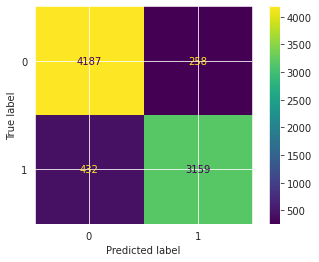

In [55]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model1, X_test, y_test, normalize = None)

In [56]:
log_model.score(X_train, y_train)

0.90741662518666

In [57]:
log_model.score(X_test, y_test)

0.9141363862618218

In [58]:
from sklearn.metrics import classification_report
target_names = df["label"].unique()
print(classification_report(
    y_true = y_test, 
    y_pred = model1.predict(X_test), 
    target_names=target_names
))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      4445
           1       0.92      0.88      0.90      3591

    accuracy                           0.91      8036
   macro avg       0.92      0.91      0.91      8036
weighted avg       0.91      0.91      0.91      8036



El modelo ha tardado 9 min 

#### Modelo 2

In [59]:
from sklearn.svm import LinearSVC
model2 = GridSearchCV(
    
    estimator = Pipeline(
        steps = [
            ("TfidfVectorizer", TfidfVectorizer(
                lowercase = True,
                max_features = 1000)),
            ("LinearSVC", LinearSVC(
                random_state=random_state,
                class_weight = {"0":1, "1":5669/4831}

             )),
        ]
    ),
    
    param_grid = {
            "TfidfVectorizer__ngram_range": [(1,1), (1,2), (1,3)],
            "LinearSVC__C": [1e-3, 1e-4, 1e-5,0.5, 1,1.5,2]
           


    },

    n_jobs = -1,
    cv = 5,
    verbose = 3
    )


In [60]:
df_copy = df.sample(frac=1)
X_train, X_test, y_train, y_test = train_test_split(df_copy["clean_text"], df_copy["label"], random_state = random_state)
print(X_train.shape)
print(y_test.shape)
print(y_train.value_counts())
print(y_test.value_counts())

(24108,)
(8036,)
0    13226
1    10882
Name: label, dtype: int64
0    4326
1    3710
Name: label, dtype: int64


In [61]:
model2.fit(X_train, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('TfidfVectorizer',
                                        TfidfVectorizer(max_features=1000)),
                                       ('LinearSVC',
                                        LinearSVC(class_weight={'0': 1,
                                                                '1': 1.1734630511281308},
                                                  random_state=1))]),
             n_jobs=-1,
             param_grid={'LinearSVC__C': [0.001, 0.0001, 1e-05, 0.5, 1, 1.5, 2],
                         'TfidfVectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)]},
             verbose=3)

In [62]:
lsvc_model = model2.best_estimator_

In [63]:
model2.best_params_

{'LinearSVC__C': 0.5, 'TfidfVectorizer__ngram_range': (1, 2)}

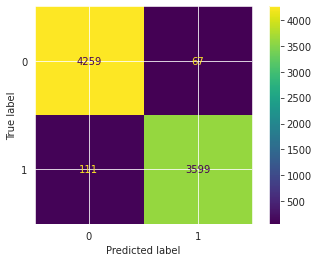

In [64]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lsvc_model, X_test, y_test, normalize = None)

In [65]:
lsvc_model.score(X_test, y_test)

0.9778496764559482

In [66]:
lsvc_model.score(X_train, y_train)

0.9856479177036669

In [67]:
from sklearn.metrics import classification_report
target_names = df["label"].unique()
print(classification_report(
    y_true = y_test, 
    y_pred = lsvc_model.predict(X_test), 
    target_names=target_names
))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4326
           1       0.98      0.97      0.98      3710

    accuracy                           0.98      8036
   macro avg       0.98      0.98      0.98      8036
weighted avg       0.98      0.98      0.98      8036



#### Modelo 3

In [70]:
from sklearn.naive_bayes import MultinomialNB
model3 = GridSearchCV(
    estimator = Pipeline(
        steps = [
            ("TfidfVectorizer", TfidfVectorizer(
                lowercase = True,
                max_features = 1000)),
            ("MultinomialNB", MultinomialNB(
                class_prior = [0.56, 0.44]
             )),
        ]
    ),
    
    param_grid = {
            "TfidfVectorizer__ngram_range": [(1,1), (1,2), (1,3)],
            "MultinomialNB__alpha": [0.01, 0.1, 1],
           


    },

    n_jobs = -1,
    cv = 5,
    verbose = 3
)


In [71]:
df_copy = df.sample(frac=1)
X_train, X_test, y_train, y_test = train_test_split(df_copy["clean_text"], df_copy["label"], random_state = random_state)
print(X_train.shape)
print(y_test.shape)
print(y_train.value_counts())
print(y_test.value_counts())

(24108,)
(8036,)
0    13125
1    10983
Name: label, dtype: int64
0    4427
1    3609
Name: label, dtype: int64


In [72]:
model3.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('TfidfVectorizer',
                                        TfidfVectorizer(max_features=1000)),
                                       ('MultinomialNB',
                                        MultinomialNB(class_prior=[0.56,
                                                                   0.44]))]),
             n_jobs=-1,
             param_grid={'MultinomialNB__alpha': [0.01, 0.1, 1],
                         'TfidfVectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)]},
             verbose=3)

In [73]:
mmb_model = model3.best_estimator_

In [74]:
mmb_model.score(X_train, y_train)

0.9239256678281068

In [75]:
mmb_model.score(X_test, y_test)

0.9232205077152812

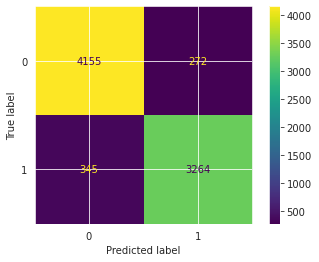

In [76]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(mmb_model, X_test, y_test, normalize = None)

In [77]:
from sklearn.metrics import classification_report
target_names = df["label"].unique()
print(classification_report(
    y_true = y_test, 
    y_pred = mmb_model.predict(X_test), 
    target_names=target_names
))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      4427
           1       0.92      0.90      0.91      3609

    accuracy                           0.92      8036
   macro avg       0.92      0.92      0.92      8036
weighted avg       0.92      0.92      0.92      8036



#### Modelo 4

In [88]:
from sklearn.neural_network import MLPClassifier

model4 = GridSearchCV(
    estimator = Pipeline(
        steps = [
            ("TfidfVectorizer", TfidfVectorizer(
                lowercase = True,
                max_features = 1000)),
            ("MLPClassifier", MLPClassifier(
                random_state=random_state
             )),
        ]
    ),
    
    param_grid = {
            "TfidfVectorizer__ngram_range": [(1,1), (1,2), (1,3)],
            "MLPClassifier__hidden_layer_sizes": [1,2],
            "MLPClassifier__early_stopping": [False,True]
            
    },

    n_jobs = -1,
    cv = 5,
    verbose = 3
)



In [95]:
df_copy = df.sample(frac=1)
X_train, X_test, y_train, y_test = train_test_split(df_copy["clean_text"], df_copy["label"], random_state = random_state)
print(X_train.shape)
print(y_test.shape)
print(y_train.value_counts())
print(y_test.value_counts())

(24108,)
(8036,)
0    13123
1    10985
Name: label, dtype: int64
0    4429
1    3607
Name: label, dtype: int64


In [96]:
model4.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('TfidfVectorizer',
                                        TfidfVectorizer(max_features=1000)),
                                       ('MLPClassifier',
                                        MLPClassifier(random_state=1))]),
             n_jobs=-1,
             param_grid={'MLPClassifier__early_stopping': [False, True],
                         'MLPClassifier__hidden_layer_sizes': [1, 2],
                         'TfidfVectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)]},
             verbose=3)

In [97]:
lsv_model = model4.best_estimator_

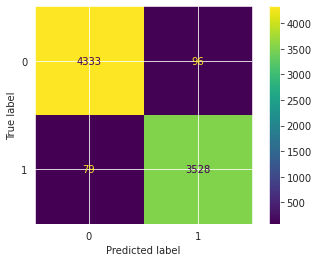

In [98]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lsv_model, X_test, y_test, normalize = None)

In [99]:
lsv_model.score(X_test, y_test)

0.9782229965156795

In [100]:
lsv_model.score(X_train, y_train)

0.982702837232454